# Simulation of ridge and ridgeless regression under noise injection

This notebook simulates the risk for ridge and ridgeless regression 

## Utility functions

In [50]:
from matplotlib import pyplot as plt
import numpy as np
import time
import os
import _pickle as pk
import scipy.stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import colors
from brokenaxes import brokenaxes

transparent_ratio = 0.2

plt.rcParams.update({ 
    "text.usetex": True,
    "font.weight": "heavy",
    "font.size": 14,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# plt.style.use('tableau-colorblind10')

## Plots

In [3]:
def f_to_param(f, param):
    if param == 'n':
        return f.split(' ')[0][1:]
    elif param == 'd':
        return f.split(' ')[1][1:]
    elif param == 'k':
        return f.split(' ')[2][1:]
    elif param == 'beta_norm':
        return f.split(' ')[3][9:]
    elif param == 'sig_eps':
        return f.split(' ')[4][7:]
    elif param == 'lamb':
        return f.split(' ')[5][4:]
    elif param == 'seed':
        return f.split(' ')[6][4:]
    elif param == 'test_n':
        return f.split(' ')[7][6:]
    elif param == 'sig_A':
        return f.split(' ')[8][5:]
    elif param == 'sim':
        return f.split(' ')[9].split('_')[0][4:] 
    elif param == 'ntrain':
        if len(f.split(' ')) > 10:
            return f.split(' ')[10].split('_')[0][6:]
        else:
            return False
    elif param == 'noYaug':
        if len(f.split(' ')) == 10:
            return f.split(' ')[9].split('_')[-1].split('.')[0] == 'noYaug'
        else:
            return False

In [4]:
r_gamma = lambda gamma, z: (1-gamma-z-np.sqrt((1-gamma-z)**2- 4*gamma*z))/(2*gamma*z)
partial_r_gamma = lambda gamma, z: ( - (-2*(-gamma-z+1)-4*gamma)/(2*np.sqrt((-gamma-z+1)**2 - 4*gamma*z)) - 1)/(2*gamma*z) - ( -np.sqrt((-gamma-z+1)**2 - 4*gamma*z) - gamma - z +1 )/(2*gamma*z**2)
R_B = lambda b, lamb, gamma: b**2 * lamb**2 * partial_r_gamma(gamma, -lamb)
R_V = lambda sigma, lamb, gamma: sigma**2 * gamma * (r_gamma(gamma, -lamb) - lamb * partial_r_gamma(gamma, -lamb))
R = lambda b, sigma, lamb, gamma: R_B(b, lamb, gamma) + R_V(sigma, lamb, gamma)

def get_theoretical_risk(sig_A, k, gamma, beta_norm, sig_eps, lamb):
    lamb_star = np.sqrt(k) * (1+sig_A**2+lamb) / np.sqrt(k+2*sig_A**2+sig_A**4) - 1
    b_star = lamb * np.sqrt(k) / ( lamb * np.sqrt(k) + np.sqrt(k) * (1+sig_A**2) - np.sqrt(k+2*sig_A**2+sig_A**4)   )
    nu_star = np.sqrt(k+sig_A**2) / np.sqrt(k + 2 * sig_A**2 + 4 * sig_A**4) \
                * np.sqrt( (k+sig_A**2)/np.sqrt(k**2+2*k*sig_A**2+k*sig_A**4) 
                          +  
                             (1 - (k+sig_A**2)/np.sqrt(k**2+2*k*sig_A**2+k*sig_A**4)) / (gamma * (1-lamb_star * r_gamma(gamma, - lamb_star) )**2 )
                         )
    return R( b_star * beta_norm, nu_star * sig_eps, lamb_star, gamma )

def get_theoretical_risk_B(sig_A, k, gamma, beta_norm, sig_eps, lamb):
    lamb_star = np.sqrt(k) * (1+sig_A**2+lamb) / np.sqrt(k+2*sig_A**2+sig_A**4) - 1
    b_star = lamb * np.sqrt(k) / ( lamb * np.sqrt(k) + np.sqrt(k) * (1+sig_A**2) - np.sqrt(k+2*sig_A**2+sig_A**4)   )
    nu_star = np.sqrt(k+sig_A**2) / np.sqrt(k + 2 * sig_A**2 + 4 * sig_A**4) \
                * np.sqrt( (k+sig_A**2)/np.sqrt(k**2+2*k*sig_A**2+k*sig_A**4) 
                          +  
                             (1 - (k+sig_A**2)/np.sqrt(k**2+2*k*sig_A**2+k*sig_A**4)) / (gamma * (1-lamb_star * r_gamma(gamma, - lamb_star) )**2 )
                         )
    return R_B( b_star * beta_norm, lamb_star, gamma )

def get_theoretical_risk_V(sig_A, k, gamma, beta_norm, sig_eps, lamb):
    lamb_star = np.sqrt(k) * (1+sig_A**2+lamb) / np.sqrt(k+2*sig_A**2+sig_A**4) - 1
    b_star = lamb * np.sqrt(k) / ( lamb * np.sqrt(k) + np.sqrt(k) * (1+sig_A**2) - np.sqrt(k+2*sig_A**2+sig_A**4)   )
    nu_star = np.sqrt(k+sig_A**2) / np.sqrt(k + 2 * sig_A**2 + 4 * sig_A**4) \
                * np.sqrt( (k+sig_A**2)/np.sqrt(k**2+2*k*sig_A**2+k*sig_A**4) 
                          +  
                             (1 - (k+sig_A**2)/np.sqrt(k**2+2*k*sig_A**2+k*sig_A**4)) / (gamma * (1-lamb_star * r_gamma(gamma, - lamb_star) )**2 )
                         )
    return R_V( nu_star * sig_eps, lamb_star, gamma )

In [36]:
def read_stat_from_f_list(f_list):
    stat_list=[]
    for file in f_list:
        print('Inspecting ' + file + '...', end='\r')
        with open(directory + '/' + file, 'rb') as f:
            stats = pk.load(f)
        stat_list.append(stats)    
       
    return stat_list, f_list[0]

def stat_plot(stat_list, x_opt='d', predict_opt=False, fname='', two_stage_opt=False, first_stage_stat_list=[], oracle_stat_list=[]):
    mean_unaug_risk = [np.mean(stats['unaug_risk_list']) for stats in stat_list]
    mean_aug_risk = [np.mean(stats['aug_risk_list']) for stats in stat_list]
    ci_upper_unaug_risk = [np.mean(stats['unaug_risk_list'])+2*np.std(stats['unaug_risk_list']) for stats in stat_list]
    ci_lower_unaug_risk = [np.mean(stats['unaug_risk_list'])-2*np.std(stats['unaug_risk_list']) for stats in stat_list]
    ci_upper_aug_risk = [np.mean(stats['aug_risk_list'])+2*np.std(stats['aug_risk_list']) for stats in stat_list]
    ci_lower_aug_risk = [np.mean(stats['aug_risk_list'])-2*np.std(stats['aug_risk_list']) for stats in stat_list]
    
    if x_opt == 'gamma':
        x = [stats['d']/stats['n'] for stats in stat_list]
    else:
        x = [stats['d'] for stats in stat_list]
    
    plt.plot(x, mean_unaug_risk, color='tab:blue', label='unaugmented')
    plt.plot(x, mean_aug_risk, color='tab:orange', label='augmented')
    
    fill_color = np.array(colors.to_rgba('tab:blue'))
    fill_color[3] *= transparent_ratio
    plt.fill_between(x, ci_upper_unaug_risk, ci_lower_unaug_risk, facecolor=fill_color)

    fill_color = np.array(colors.to_rgba('tab:orange'))
    fill_color[3] *= transparent_ratio
    plt.fill_between(x, ci_upper_aug_risk, ci_lower_aug_risk, facecolor=fill_color)
    
    if predict_opt == True:
        sig_A = float(f_to_param(fname, 'sig_A'))
        k = int(f_to_param(fname, 'k'))
        beta_norm = float(f_to_param(fname, 'beta_norm'))
        sig_eps = float(f_to_param(fname, 'sig_eps'))
        lamb = float(f_to_param(fname, 'lamb'))

        gamma = [stats['d']/stats['n'] for stats in stat_list]
        theoretical_aug_risk = [get_theoretical_risk(sig_A, k, gamma_single, beta_norm, sig_eps, lamb + 0.00000001) for gamma_single in gamma]
        theoretical_unaug_risk = [get_theoretical_risk(0, 1, gamma_single, beta_norm, sig_eps, lamb + 0.00000001) for gamma_single in gamma]

        plt.plot(x, theoretical_unaug_risk, color='tab:cyan', linestyle='dashed', label='unaugmented, theoretical')
        plt.plot(x, theoretical_aug_risk, color='tab:red', linestyle='dashed', label='augmented, theoretical')
        
    if two_stage_opt == True:
        for sub_stat_list, plot_color, risk_prop, plot_label in [(first_stage_stat_list, 'tab:green', 'unaug_risk_list', 'first stage'), 
                                                             (oracle_stat_list, 'tab:brown', 'aug_risk_list', 'oracle')]:
            if len(sub_stat_list) == 0: 
                continue 
            if x_opt == 'gamma':
                x = [stats['d']/stats['n'] for stats in sub_stat_list]
            else:
                x = [stats['d'] for stats in sub_stat_list]

            mean_risk = [np.mean(stats[risk_prop]) for stats in sub_stat_list]
            ci_upper_risk = [np.mean(stats[risk_prop])+2*np.std(stats[risk_prop]) for stats in sub_stat_list]
            ci_lower_risk = [np.mean(stats[risk_prop])-2*np.std(stats[risk_prop]) for stats in sub_stat_list]

            plt.plot(x, mean_risk, color=plot_color, label=plot_label, linestyle='dotted')

            fill_color = np.array(colors.to_rgba(plot_color))
            fill_color[3] *= transparent_ratio
            plt.fill_between(x, ci_upper_risk, ci_lower_risk, facecolor=fill_color)
    


# Oracle

In [57]:
## INSPECTING
directory = 'noise_inject'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
oracle_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == False and f_to_param(f,'noYaug')  == False ]

oracle_stat_list, oracle_fname = read_stat_from_f_list( oracle_f_list )

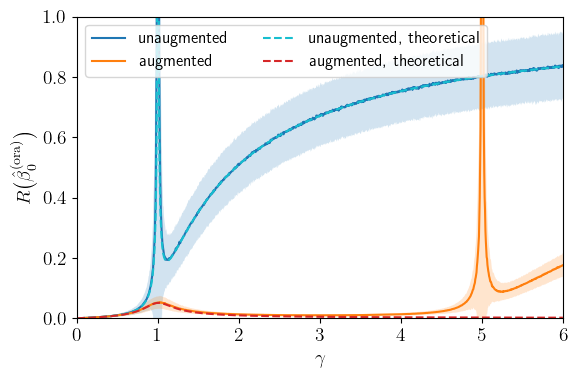

In [58]:
## ORACLE INTRO

fig = plt.figure(figsize=(6, 4), dpi=100)

stat_plot(oracle_stat_list, 'gamma', predict_opt=True, fname=oracle_fname)
    
plt.legend(loc='upper left', prop={'size': 12}, ncol=2)
plt.ylabel(r'$R \big(\hat \beta_0^{(\rm ora)}\big)$')
plt.xlabel(r'$\gamma$')
plt.xlim([0,6])
plt.ylim([0,1])

plt.tight_layout()
plt.savefig('fig2_noise_inject_oracle_ridgeless.pdf', dpi=fig.dpi, bbox_inches='tight')

In [72]:
## INSPECTING
directory = 'noise_inject_ridge_oracle'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
oracle_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0.1' and f_to_param(f,'ntrain')  == False and f_to_param(f,'noYaug')  == False ]

oracle_stat_list, oracle_fname = read_stat_from_f_list( oracle_f_list )

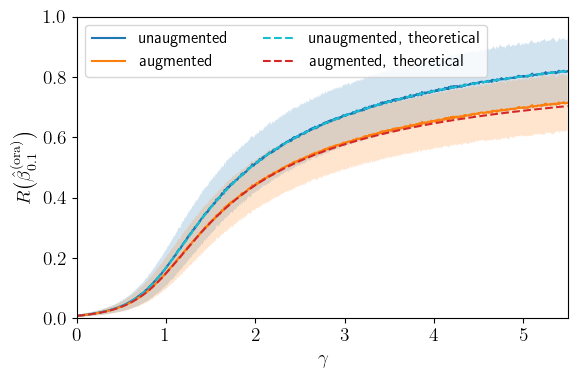

In [73]:
## ORACLE RIDGE

fig = plt.figure(figsize=(6, 4), dpi=100)

stat_plot(oracle_stat_list, 'gamma', predict_opt=True, fname=oracle_fname)
    
plt.legend(loc='upper left', prop={'size': 12}, ncol=2)
plt.ylabel(r'$R \big(\hat \beta_{0.1}^{(\rm ora)}\big)$')
plt.xlabel(r'$\gamma$')
plt.xlim([0,5.5])
plt.ylim([0,1])

plt.tight_layout()
plt.savefig('fig6_2_noise_inject_oracle_ridge.pdf', dpi=fig.dpi, bbox_inches='tight')

# Two-stage

In [64]:
## INSPECTING
directory = 'noise_inject'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == '100' ]
split_stat_list, split_fname = read_stat_from_f_list( split_f_list )

directory = 'noise_inject_practical_pred'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_unaug_list = [f for f in file_list if f_to_param(f,'n') == '100' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'noYaug')  == True ]
split_unaug_stat_list, split_unaug_fname = read_stat_from_f_list( split_unaug_list )

directory = 'noise_inject_oracle_compare'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
oracle_f_list = [f for f in file_list if f_to_param(f,'n') == '100' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == False and f_to_param(f,'noYaug')  == False ]
oracle_stat_list, oracle_fname = read_stat_from_f_list( oracle_f_list )

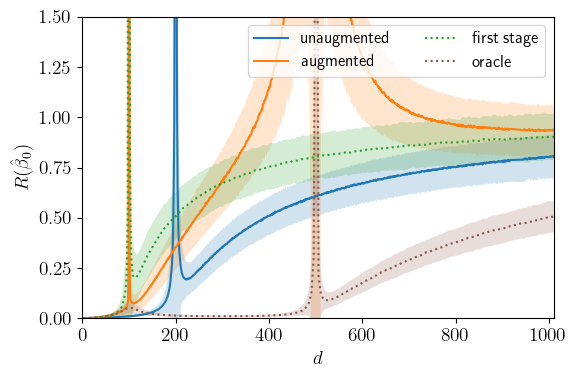

In [65]:
## HALF SPLIT

fig = plt.figure(figsize=(6, 4), dpi=100)

stat_plot(split_stat_list, 'd', two_stage_opt=True, first_stage_stat_list=split_unaug_stat_list, oracle_stat_list=oracle_stat_list)
    
plt.legend(loc='upper right', prop={'size': 12}, ncol=2)
plt.ylabel(r'$R(\hat \beta_0)$')
plt.xlabel(r'$d$')
plt.xlim([0,1010])
plt.ylim([0,1.5])

plt.tight_layout()
plt.savefig('fig7_1_halfsplit.pdf', dpi=fig.dpi, bbox_inches='tight')

In [66]:
## INSPECTING
directory = 'noise_inject'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == '150' ]
split_stat_list, split_fname = read_stat_from_f_list( split_f_list )

directory = 'noise_inject_practical_pred'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_unaug_list = [f for f in file_list if f_to_param(f,'n') == '150' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'noYaug')  == True ]
split_unaug_stat_list, split_unaug_fname = read_stat_from_f_list( split_unaug_list )

directory = 'noise_inject_oracle_compare'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
oracle_f_list = [f for f in file_list if f_to_param(f,'n') == '50' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == False and f_to_param(f,'noYaug')  == False ]
oracle_stat_list, oracle_fname = read_stat_from_f_list( oracle_f_list )

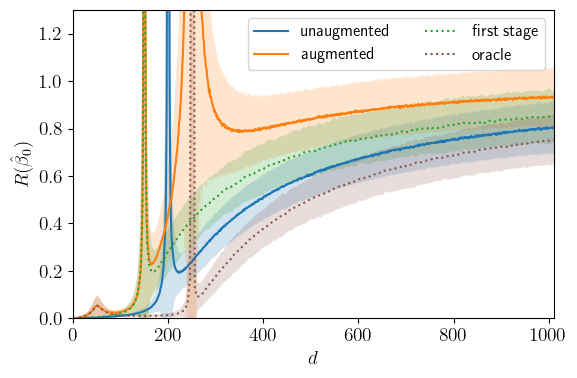

In [67]:
## THREE QUARTERS SPLIT

fig = plt.figure(figsize=(6, 4), dpi=100)

stat_plot(split_stat_list, 'd', two_stage_opt=True, first_stage_stat_list=split_unaug_stat_list, oracle_stat_list=oracle_stat_list)
    
plt.legend(loc='upper right', prop={'size': 12}, ncol=2)
plt.ylabel(r'$R(\hat \beta_0)$')
plt.xlabel(r'$d$')
plt.xlim([0,1010])
plt.ylim([0,1.3])

plt.tight_layout()
plt.savefig('fig7_2_threequartersplit.pdf', dpi=fig.dpi, bbox_inches='tight')

In [68]:
## INSPECTING
directory = 'noise_inject'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == '50' ]
split_stat_list, split_fname = read_stat_from_f_list( split_f_list )

directory = 'noise_inject_practical_pred'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_unaug_list = [f for f in file_list if f_to_param(f,'n') == '50' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'noYaug')  == True ]
split_unaug_stat_list, split_unaug_fname = read_stat_from_f_list( split_unaug_list )


directory = 'noise_inject_oracle_compare'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
oracle_f_list = [f for f in file_list if f_to_param(f,'n') == '150' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == False and f_to_param(f,'noYaug')  == False ]
oracle_stat_list, oracle_fname = read_stat_from_f_list( oracle_f_list )

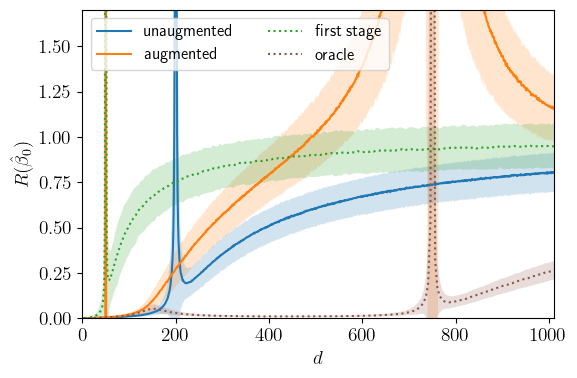

In [69]:
## QUARTER SPLIT

fig = plt.figure(figsize=(6, 4), dpi=100)

stat_plot(split_stat_list, 'd', two_stage_opt=True, first_stage_stat_list=split_unaug_stat_list, oracle_stat_list=oracle_stat_list)
    
plt.legend(loc='upper left', prop={'size': 12}, ncol=2)
plt.ylabel(r'$R(\hat \beta_0)$')
plt.xlabel(r'$d$')
plt.xlim([0,1010])
plt.ylim([0,1.7])

plt.tight_layout()
plt.savefig('fig7_3_quartersplit.pdf', dpi=fig.dpi, bbox_inches='tight')

In [70]:
## INSPECTING
directory = 'noise_inject_noYaug'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
split_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'noYaug')  == True ]
split_stat_list, split_fname = read_stat_from_f_list( split_f_list )

directory = 'noise_inject'

file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
file_list.sort(key=lambda f: int(f_to_param(f,'d')))
oracle_f_list = [f for f in file_list if f_to_param(f,'n') == '200' and f_to_param(f,'lamb')  == '0' and f_to_param(f,'ntrain')  == False and f_to_param(f,'noYaug')  == False ]
oracle_stat_list, oracle_fname = read_stat_from_f_list( oracle_f_list )

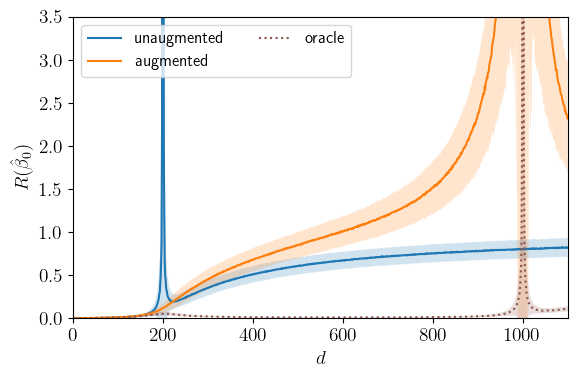

In [71]:
## NO Y AUG

fig = plt.figure(figsize=(6, 4), dpi=100)

stat_plot(split_stat_list, 'd', two_stage_opt=True, first_stage_stat_list=[], oracle_stat_list=oracle_stat_list)
    
plt.legend(loc='upper left', prop={'size': 12}, ncol=2)
plt.ylabel(r'$R(\hat \beta_0)$')
plt.xlabel(r'$d$')
plt.xlim([0,1100])
plt.ylim([0,3.5])

plt.tight_layout()
plt.savefig('fig7_4_noYaug.pdf', dpi=fig.dpi, bbox_inches='tight')